In [1]:
import torch
import matplotlib.pyplot as plt
from torch import optim, distributions, nn
from tqdm.notebook import tqdm
import gpzoo
from gpzoo.kernels import NSF_RBF, batched_RBF, batched_Matern32
from gpzoo.gp import GaussianPrior, WSVGP
from gpzoo.likelihoods import PNMF, NSF2, Hybrid_NSF2
from gpzoo.utilities import train_hybrid, train_hybrid_batched, anndata_to_train_val, plot_factors, rescale_spatial_coords, add_jitter, init_softplus, whitened_KL
import squidpy as sq
import numpy as np
from sklearn.decomposition import NMF
import scanpy as sc
import random

from gpzoo.utilities import regularized_nmf, dims_autocorr
from matplotlib.animation import FuncAnimation
from matplotlib import animation
import pickle
from sklearn.cluster import KMeans

/gladstone/engelhardt/home/lchumpitaz/gitclones/GPzoo/gpzoo/utilities.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def plot_factors(factors, X, moran_idx=None, ax=None, size=7, alpha=0.8, s=0.1, names=None):

    max_val = np.percentile(factors, 99)
    min_val = np.percentile(factors, 1)

    
    if moran_idx is not None:
        factors = factors[moran_idx]
        if names is not None:
            names = names[moran_idx]

    L = len(factors)

    if ax is None:
        fig, ax = plt.subplots(2, 6, figsize=(size*6, size*2), tight_layout=True)
        
    for i in range(L):
        
        
        curr_ax = ax[i//6, i%6]
        
        
        
        curr_ax.scatter(X[:, 0], X[:,1], c=factors[i], vmin=min_val, vmax=max_val, alpha=alpha, cmap='turbo', s=s)

        curr_ax.invert_yaxis()
        if names is not None:
            curr_ax.set_title(names[i], x=0.03, y=.88, fontsize="small", c="white",
                     ha="left", va="top")
        curr_ax.set_xticks([])
        curr_ax.set_yticks([])
        curr_ax.set_facecolor('xkcd:gray')

In [3]:
adata = sq.datasets.slideseqv2()
adata = adata.raw.to_adata()

/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/gpzoo/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/gpzoo/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


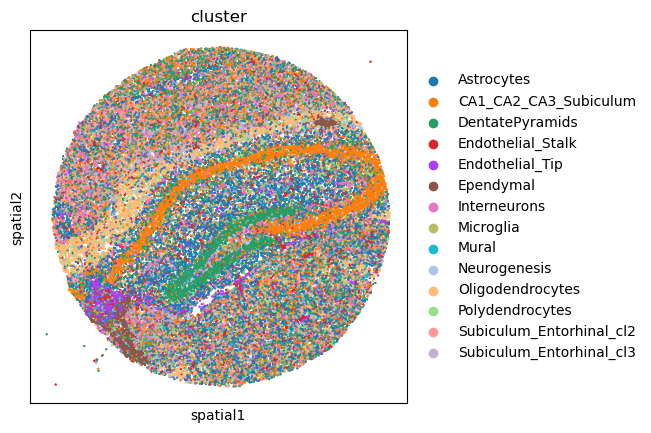

In [4]:
sq.pl.spatial_scatter(adata, color="cluster", size=1, shape=None);


<Axes: >

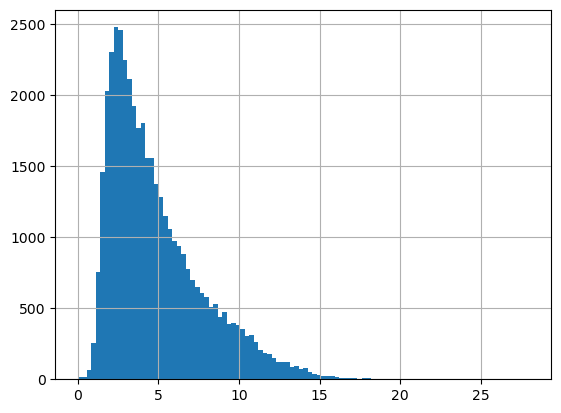

In [5]:
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)
adata.obs.pct_counts_mt.hist(bins=100)


In [6]:
adata = adata[adata.obs.pct_counts_mt < 20] #from 53K to 45K
sc.pp.filter_cells(adata, min_counts=100)
sc.pp.filter_genes(adata, min_cells=10)

/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/gpzoo/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_counts"] = number


In [7]:
Dtr, Dval = anndata_to_train_val(adata, sz="scanpy")

In [8]:
Y = Dtr['Y'].T
Y = Y[~adata.var.MT]
X = Dtr['X']*50
V = Dtr['sz']

In [9]:
Y.shape

(17702, 39694)

In [10]:
Y.shape

(17702, 39694)

In [271]:
nmf_model = NMF(n_components=24, max_iter=3000, init='random', random_state=420, alpha_H=1e-4)

In [272]:
nmf_model.fit(Y.T)

/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/gpzoo/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 3000 reached. Increase it to improve convergence.
  warnings.warn(


NMF(alpha_H=0.0001, init='random', max_iter=3000, n_components=24,
    random_state=420)

In [273]:
exp_factors = nmf_model.transform(Y.T/V)
factors = np.log(exp_factors + 1e-2)
loadings = nmf_model.components_.T

In [274]:
moran_idx, moranI = dims_autocorr(np.exp(factors), X)

here_andata


In [275]:
moranI

array([0.72654798, 0.70383828, 0.69518725, 0.64150753, 0.62895078,
       0.57278532, 0.54936105, 0.51552861, 0.51497114, 0.40297733,
       0.37607005, 0.35328121, 0.33980991, 0.30318516, 0.27773057,
       0.26741736, 0.23622509, 0.18059374, 0.14966655, 0.14297687,
       0.0874774 , 0.08133798, 0.05642941, 0.03542622])

In [276]:
factors_ordered=factors[:, moran_idx]
loadings_ordered=loadings[:, moran_idx]

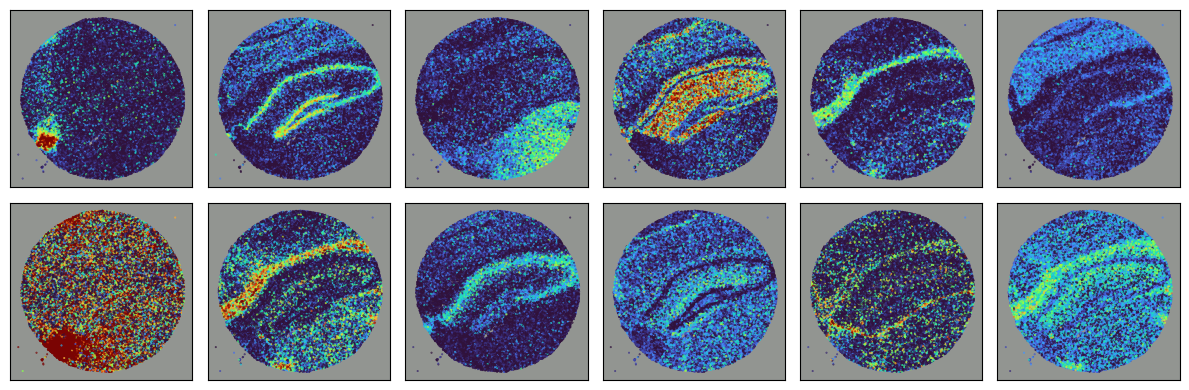

In [277]:
plot_factors(np.exp(factors.T), X, moran_idx=moran_idx[:12], ax=None, size=2, s=0.2, alpha=0.9)